In [1]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import os
## plase change to folder path
working_dir = "/home/zhuoyan/nlp/Induction-Head"
# working_dir = "/Users/zyxu/Documents/py/NLP/induction_head/induc_head"
os.chdir(working_dir)
import json 
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from src.config import Config
from src.model import TFModel
from src.data import gen_simple_data
from src.utils import fix_random_seed, create_folder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2.1.0+cu121
2.1.0+cu121
2.1.0+cu121
using device:  cuda
2.1.0+cu121


In [2]:
seed = 2023
fix_random_seed(seed)

        
save_plot = True
save_plot_dir = f'Figs/seed_{seed}'

create_folder('Figs')
create_folder(f'Figs/seed_{seed}')

### Step 1: setting up model and data 
- Simplification: pos embedding and token embedding trainable and initialized from canonical basis
- Without doing so, model cannot learn well

In [3]:
### set up hyperparameters in ./config/config.yaml
with open('./config/config_layer3.yaml', 'r') as file:
    config_args = yaml.safe_load(file)
# Create config object
config = Config(**config_args)

config.__dict__

{'vocab_size': 5,
 'd_model': 65,
 'num_heads': 1,
 'max_seq_len': 60,
 'add_embed': True,
 'init_weight': None,
 'train_from_scratch': False,
 'residual': True,
 'dropout': 0.1,
 'norm': True,
 'outdim_truncate': False,
 'trainable': [True, True],
 'ff_dim': None,
 'sample_size': 4000,
 'sample_size_test': 1000,
 'num_epoch': 800,
 'batch_size': 64,
 'fancy_opt': False,
 'use_wd': True,
 'lr': 0.001,
 'wd': '5e-4',
 'wd_2': 0,
 'num_layers': 3,
 'ckpt_path': './save/layer3/run1'}

In [4]:
vocab_size = config.vocab_size
max_seq_len = config.max_seq_len
sample_size = config.sample_size
sample_size_test = config.sample_size_test
num_epoch = config.num_epoch
setting_params = {
    'vocab_size' : config.vocab_size, 
    'max_seq_len': config.max_seq_len,
    'sample_size': config.sample_size,
    'sample_size_test': config.sample_size_test,
    'num_epoch': config.num_epoch,
    'batch_size': config.batch_size
}
num_heads = config.num_heads
num_layers = config.num_layers 
# num_layers = 2

In [5]:
vocab = torch.arange(config.vocab_size).type(torch.LongTensor)

src, src_test = torch.zeros(config.sample_size,config.max_seq_len).long(), torch.zeros(config.sample_size_test,config.max_seq_len).long()
src[range(0,config.sample_size),:] = gen_simple_data(vocab, config.max_seq_len, config.sample_size, pattern='random')
src_test[range(0,config.sample_size_test),:] = gen_simple_data(vocab, config.max_seq_len, config.sample_size_test, pattern='random')
d_model = config.vocab_size + config.max_seq_len

src = src.to(DEVICE)
src_test = src_test.to(DEVICE)

In [6]:
src

tensor([[2, 2, 1,  ..., 3, 2, 1],
        [4, 4, 3,  ..., 4, 2, 4],
        [1, 2, 0,  ..., 0, 1, 3],
        ...,
        [0, 3, 2,  ..., 4, 3, 3],
        [4, 1, 2,  ..., 2, 0, 4],
        [0, 2, 0,  ..., 3, 1, 2]], device='cuda:0')

In [7]:
# train model in main.py and load it here:
# ckpt_name = "best_err.pth"
ckpt_name = "epoch-last.pth"

ckpt_path = f"./save/layer3/run1/{ckpt_name}"

ckpt = torch.load(ckpt_path, map_location=torch.device(DEVICE))

ckpt.keys()

dict_keys(['model_dict', 'err_arr'])

In [8]:
model_dict = ckpt['model_dict']
err_arr = ckpt['err_arr']

In [9]:
for id, (name, param) in enumerate(ckpt['model_dict'].items()):
    print(id, name)

0 embed.embed.weight
1 pos_embed.pe.weight
2 h.0.mha.W_q.weight
3 h.0.mha.W_q.bias
4 h.0.mha.W_k.weight
5 h.0.mha.W_k.bias
6 h.0.mha.W_v.weight
7 h.0.mha.W_v.bias
8 h.0.mha.W_o.weight
9 h.0.mha.W_o.bias
10 h.0.layer_norm.weight
11 h.0.layer_norm.bias
12 h.1.mha.W_q.weight
13 h.1.mha.W_q.bias
14 h.1.mha.W_k.weight
15 h.1.mha.W_k.bias
16 h.1.mha.W_v.weight
17 h.1.mha.W_v.bias
18 h.1.mha.W_o.weight
19 h.1.mha.W_o.bias
20 h.1.layer_norm.weight
21 h.1.layer_norm.bias
22 h.2.mha.W_q.weight
23 h.2.mha.W_q.bias
24 h.2.mha.W_k.weight
25 h.2.mha.W_k.bias
26 h.2.mha.W_v.weight
27 h.2.mha.W_v.bias
28 h.2.mha.W_o.weight
29 h.2.mha.W_o.bias
30 h.2.layer_norm.weight
31 h.2.layer_norm.bias
32 layer_norm.weight
33 layer_norm.bias
34 fc.weight
35 fc.bias


In [10]:
###### set up model
model = TFModel(config, num_hidden_layers=num_layers)
model

TFModel(
  (embed): Embedding(
    (embed): Embedding(5, 65)
  )
  (pos_embed): PositionalEmbedding(
    (pe): Embedding(60, 65)
  )
  (h): ModuleList(
    (0-2): 3 x TFBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=65, out_features=65, bias=True)
        (W_k): Linear(in_features=65, out_features=65, bias=True)
        (W_v): Linear(in_features=65, out_features=65, bias=True)
        (W_o): Linear(in_features=65, out_features=65, bias=True)
      )
      (layer_norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (layer_norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=65, out_features=5, bias=True)
)

In [11]:
model.load_state_dict(ckpt['model_dict'])
model = model.to(DEVICE)
# for name, param in model.state_dict().items():
#     model.state_dict()[name] = param.to(DEVICE)

In [12]:
model.state_dict()["h.0.mha.W_v.bias"].is_cuda

True

### Visualization

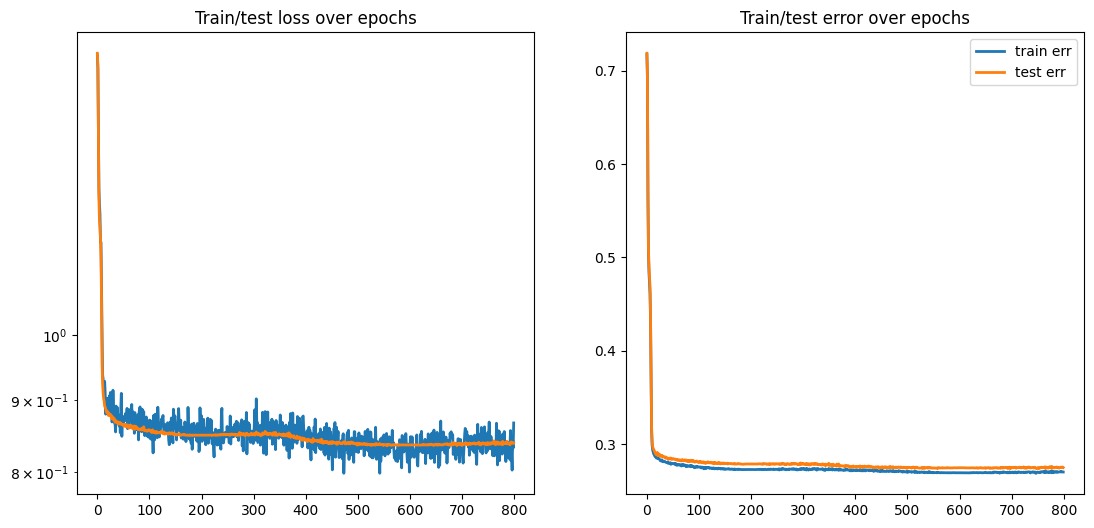

In [13]:
from src.utils import plot_err_curve
plot_err_curve(err_arr, fig_name=f'model_L{num_layers}H{num_heads}_train_test_curves', save_dir=save_plot_dir)

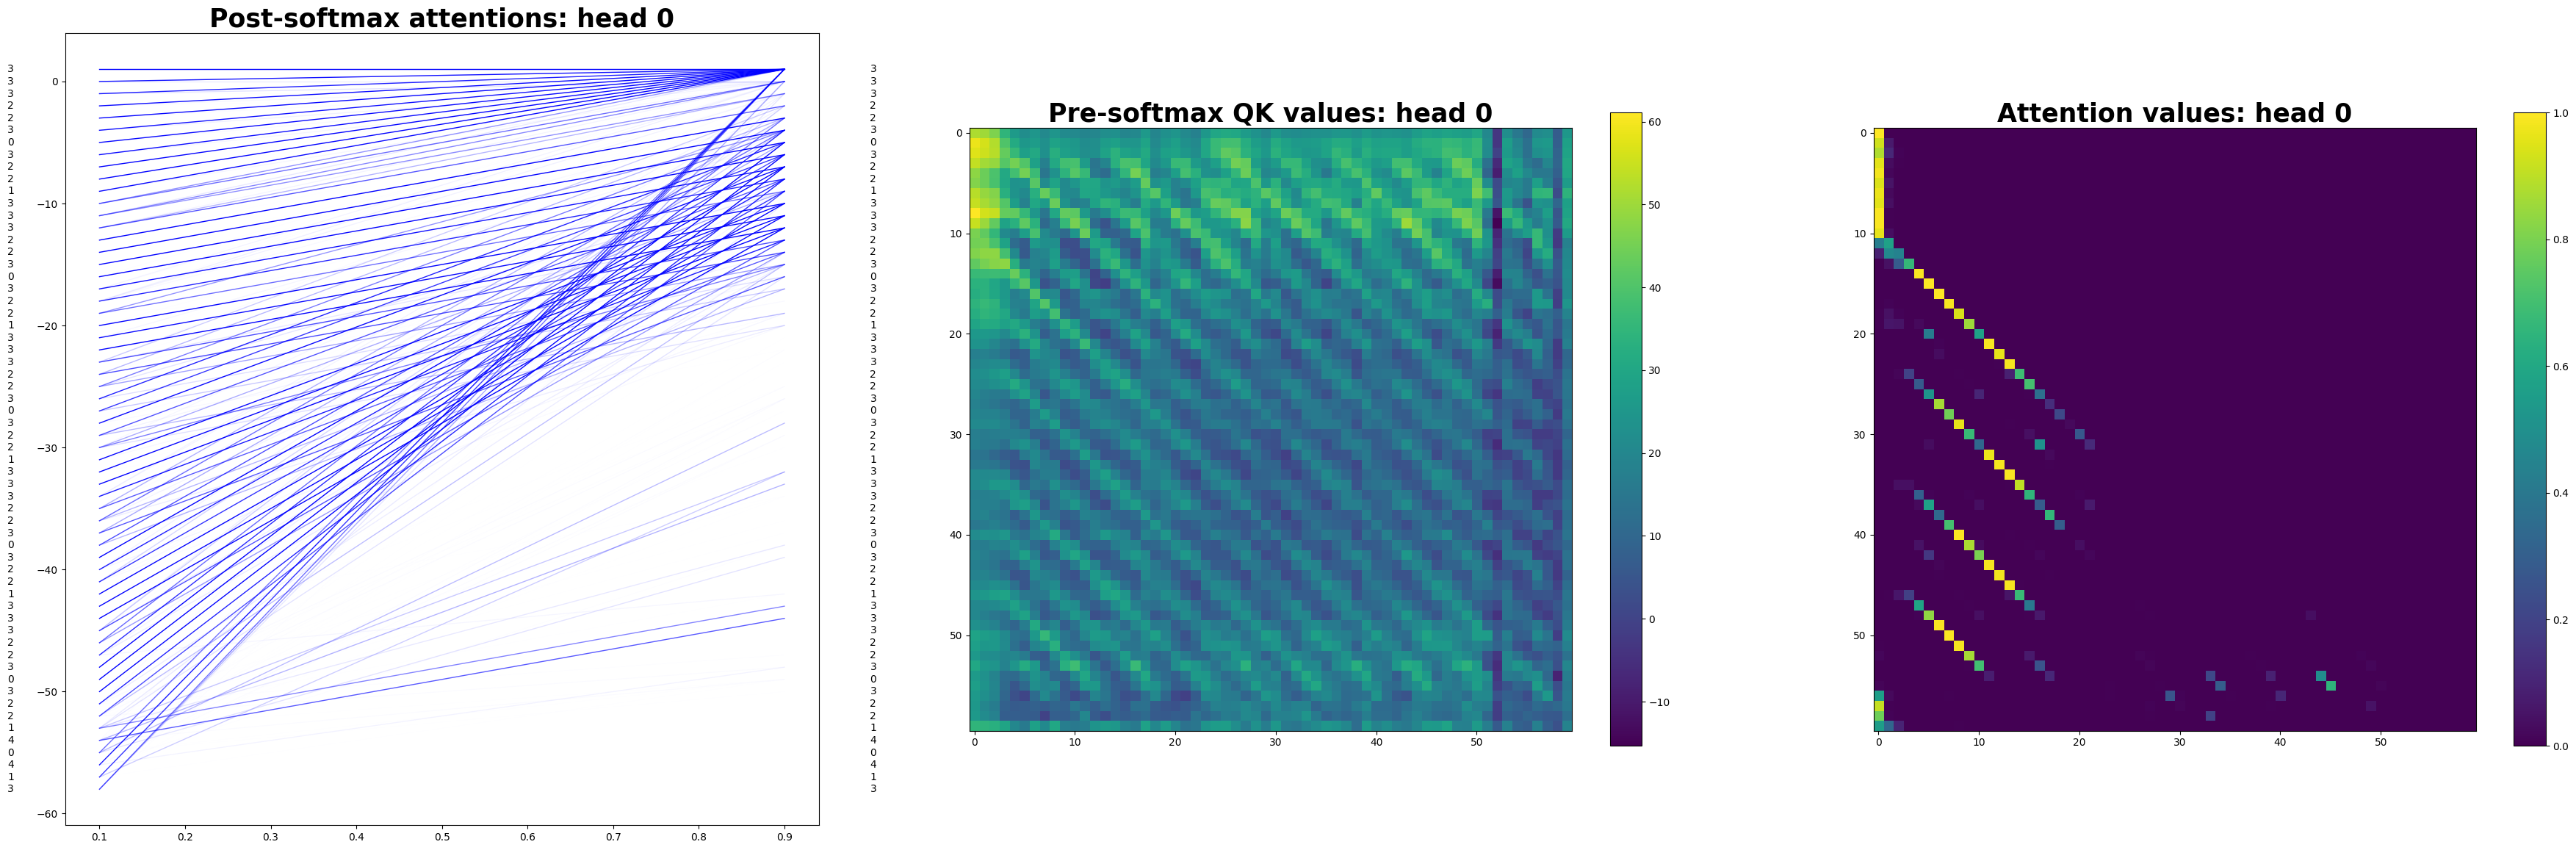

In [14]:
from src.utils import plot_attention

if num_layers == 1:
    QK_vals, attn = plot_attention(model, src_test[0,:], fig_name=f'model_L{num_layers}H{num_heads}_attn_plot', 
                               savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=0)
elif num_layers == 2:
    QK_vals2, attn2 = plot_attention(model, src_test[0,:], fig_name=f'model_L{num_layers}H{num_heads}_attn2_plot', 
                                   savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=1)
elif num_layers == 3:
    QK_vals2, attn2 = plot_attention(model, src_test[0,:], fig_name=f'model_L{num_layers}H{num_heads}_attn3_plot', 
                                   savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=2)

In [16]:
src_test[0,:]

tensor([3, 3, 3, 2, 2, 3, 0, 3, 2, 2, 1, 3, 3, 3, 2, 2, 3, 0, 3, 2, 2, 1, 3, 3,
        3, 2, 2, 3, 0, 3, 2, 2, 1, 3, 3, 3, 2, 2, 3, 0, 3, 2, 2, 1, 3, 3, 3, 2,
        2, 3, 0, 3, 2, 2, 1, 4, 0, 4, 1, 3], device='cuda:0')

In [17]:
src

tensor([[2, 2, 1,  ..., 3, 2, 1],
        [4, 4, 3,  ..., 4, 2, 4],
        [1, 2, 0,  ..., 0, 1, 3],
        ...,
        [0, 3, 2,  ..., 4, 3, 3],
        [4, 1, 2,  ..., 2, 0, 4],
        [0, 2, 0,  ..., 3, 1, 2]], device='cuda:0')

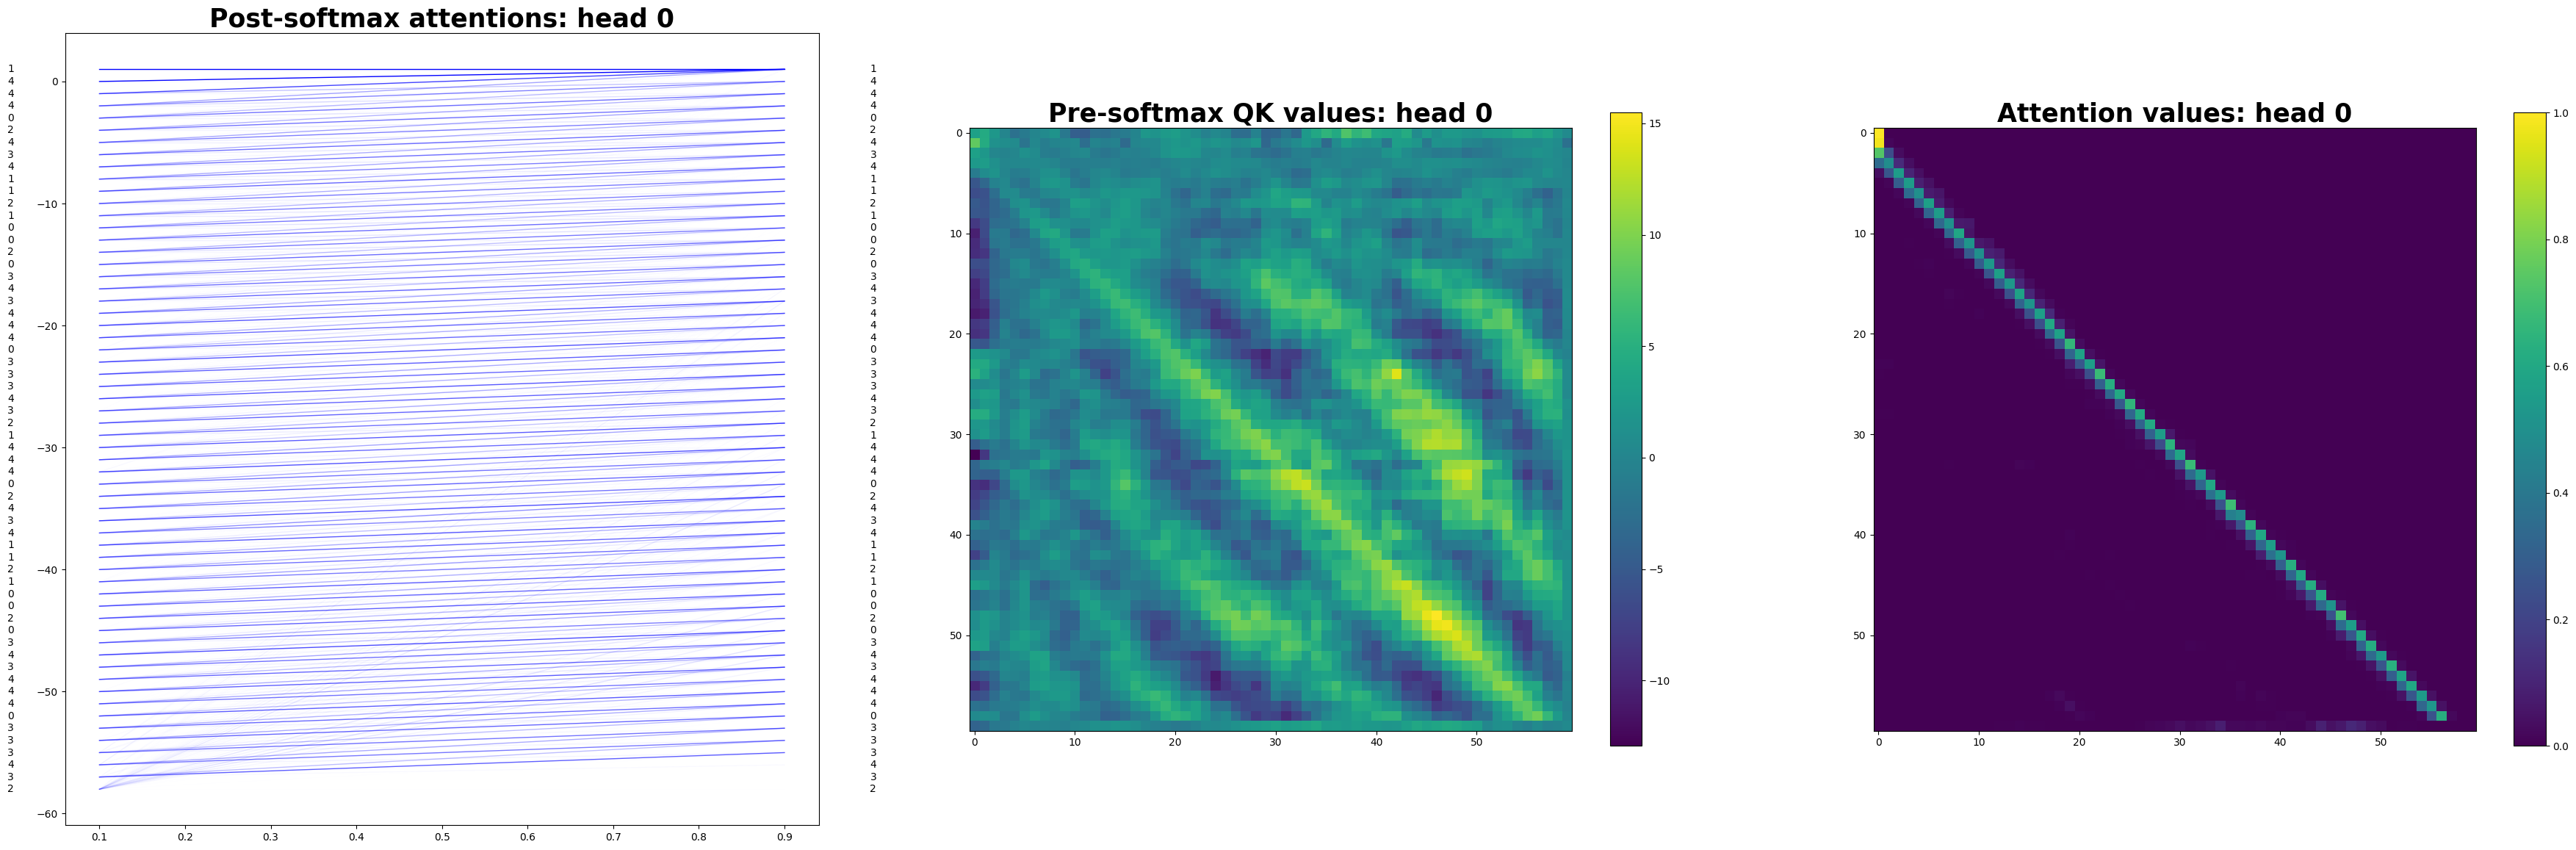

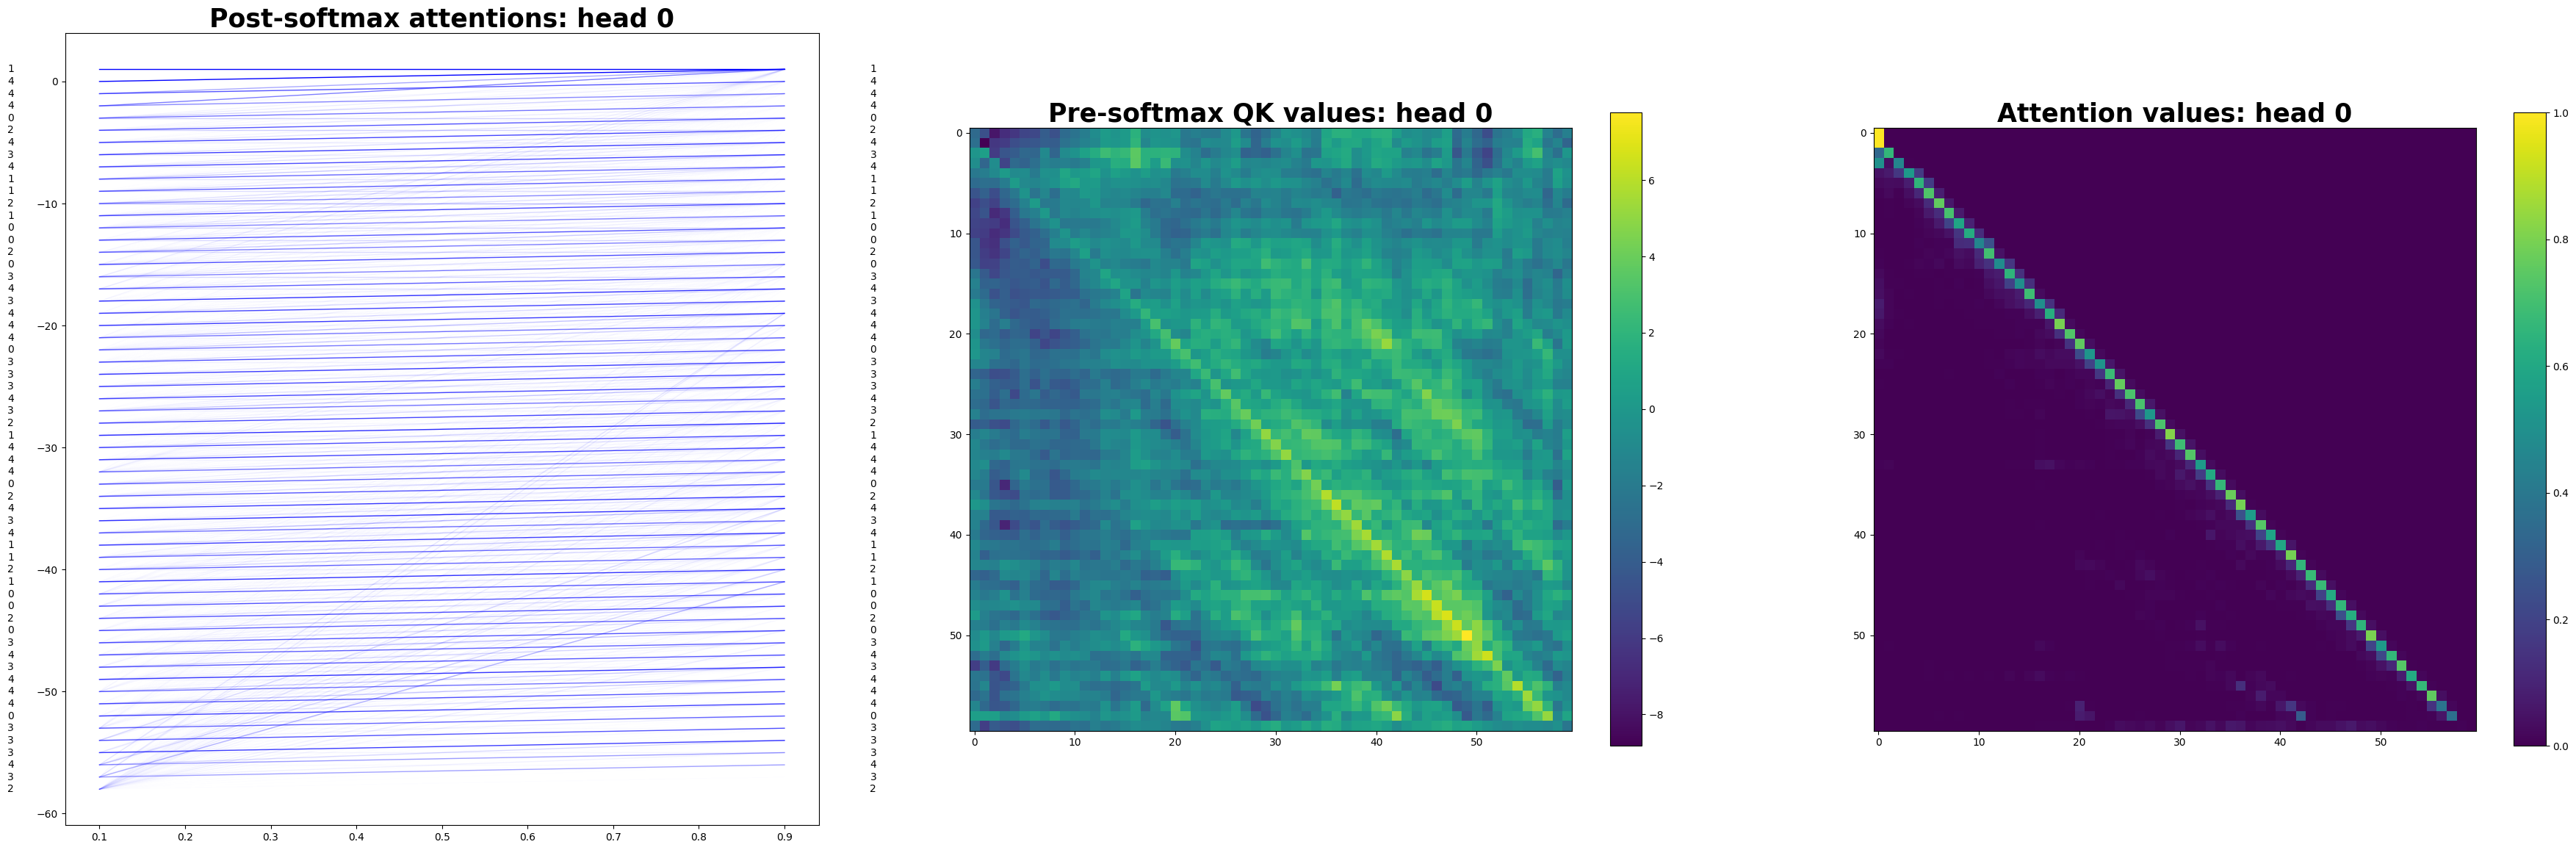

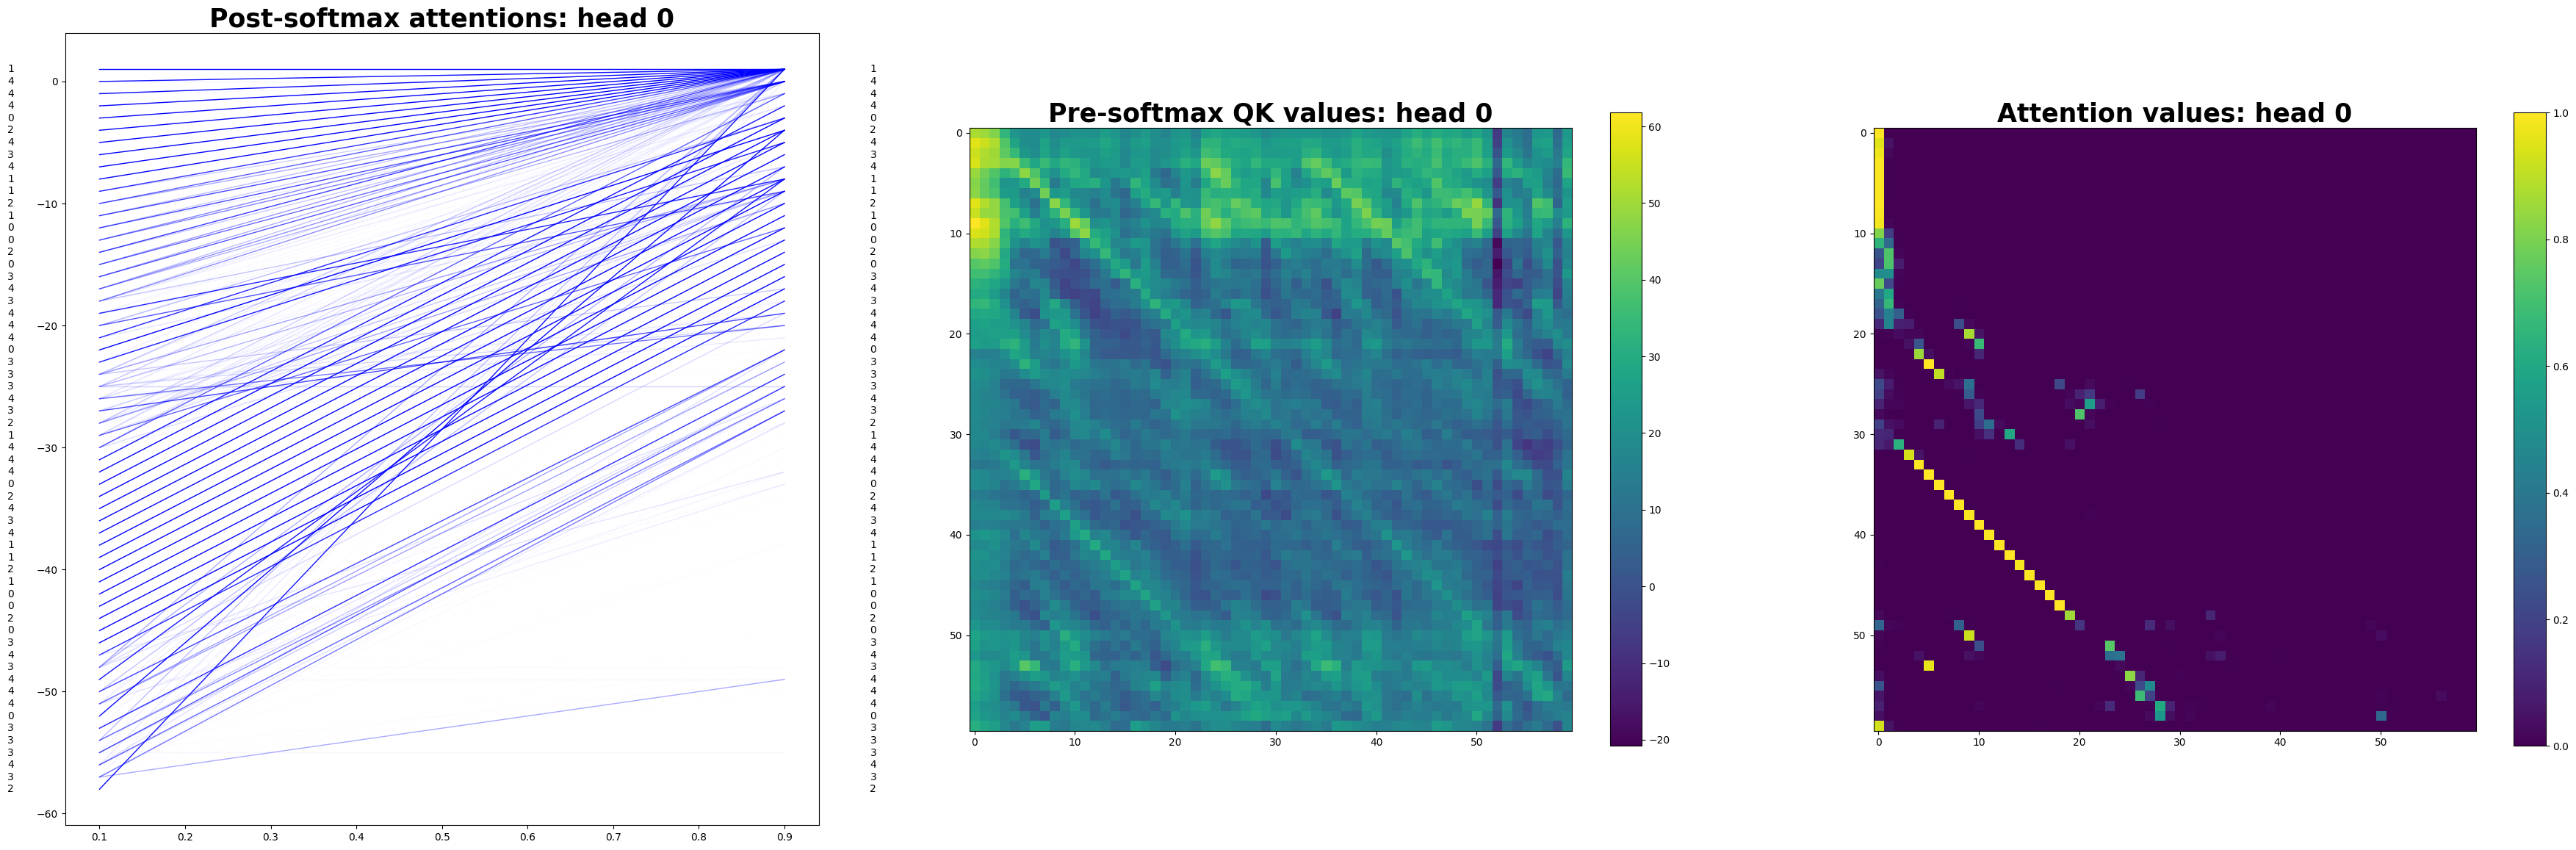

In [19]:
len_pattern = 30
pattern = torch.multinomial(torch.ones(vocab_size)/vocab_size, len_pattern, replacement=True)

src_rand_rep = gen_simple_data(vocab, max_seq_len, sample_size, pattern=pattern)
src = src_rand_rep[0,:]
src = src.to(DEVICE)
QK_vals, attn = plot_attention(model, src, fig_name='attn_rand_rep_plot', 
                               savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=0)
if num_layers == 2:
    QK_vals2, attn2 = plot_attention(model, src, fig_name='attn2_rand_rep_plot', 
                                   savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=1)
if num_layers == 3:
    QK_vals2, attn2 = plot_attention(model, src, fig_name='attn2_rand_rep_plot', 
                                   savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=1)
    QK_vals3, attn3 = plot_attention(model, src, fig_name='attn3_rand_rep_plot', 
                                   savefig_dir=save_plot_dir, num_heads=num_heads, is_mask=True, layer=2)

### Step 2: What is the property of trained TF?

In [26]:
id = 2


W_q = model.h[id].mha.W_q.weight.numpy(force=True)
W_k = model.h[id].mha.W_k.weight.numpy(force=True)
W_v = model.h[id-1].mha.W_v.weight.numpy(force=True)
W_o = model.h[id-1].mha.W_o.weight.numpy(force=True)
W_qk = W_q.T @ W_k / np.sqrt(d_model)
W_ov = W_o @ W_v

### Step 2-1: visualizing QK and OV

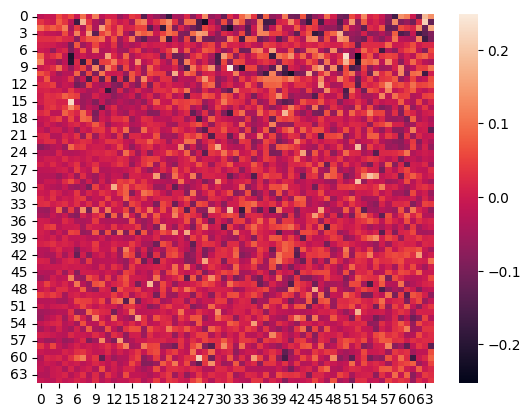

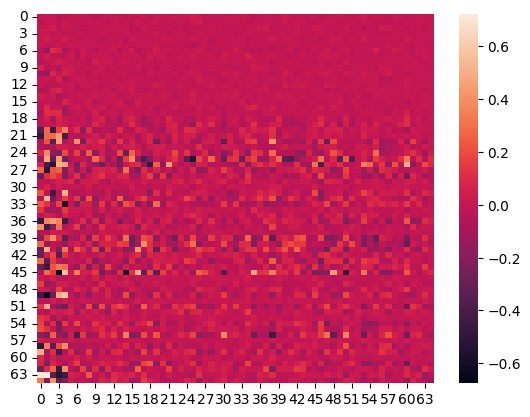

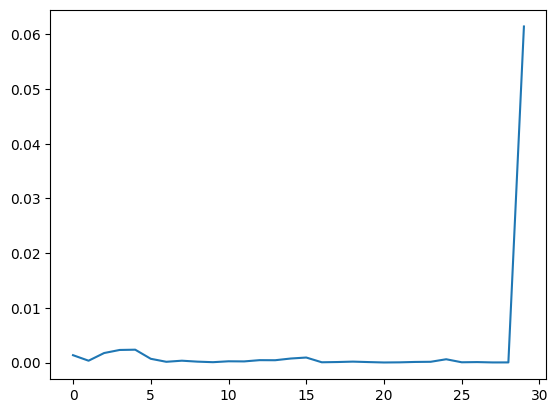

In [27]:
sns.heatmap(W_qk)
plt.show()
sns.heatmap(W_ov)
plt.show()

b_q = model.h[id].mha.W_q.bias.numpy(force=True)
b_k = model.h[id].mha.W_k.bias.numpy(force=True)
beta_q = (W_q.T @ b_k.reshape(-1,1)).ravel()  / np.sqrt(d_model)
beta_k = (W_k @ b_q.reshape(-1,1)).ravel() / np.sqrt(d_model)

vals = np.zeros(len_pattern)
for j in range(len_pattern):
    vals[j] = attn2.squeeze()[len_pattern+j,j+1]
plt.plot(vals) # check whether induction head appears, and yes!
plt.show()

### Step 2-2: visualizing QKOV matrix, close to identity map in the token embedding subspace

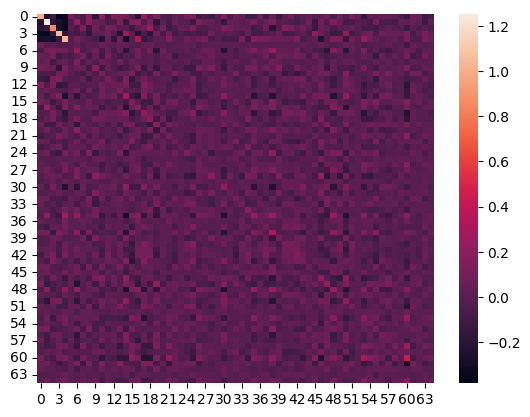

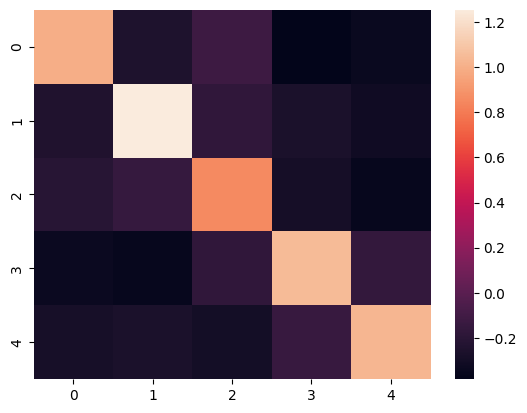

In [28]:
W_qkov = W_qk @ W_ov

sns.heatmap(W_qkov)
plt.show()
sns.heatmap(W_qkov[:vocab_size, :vocab_size])
plt.show()

### Step 2-3: How does QK and OV match?

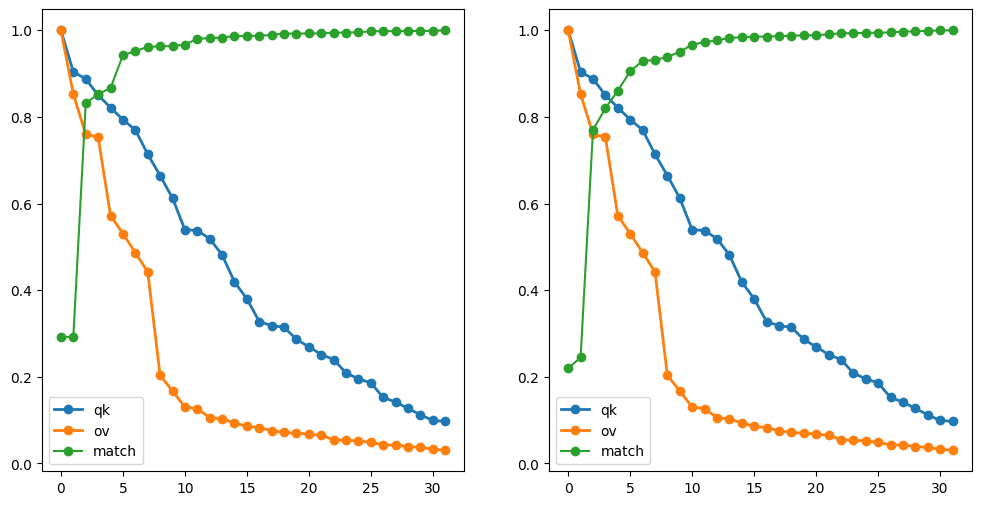

In [29]:
num_svals_plot = 32

U_qk, s_qk, Vt_qk = np.linalg.svd(W_qk)
U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov)

s_match = np.zeros((2,num_svals_plot))
for j in range(num_svals_plot):
    _, s, _ = np.linalg.svd(Vt_qk[:(j+1),:] @ U_ov[:,:(j+1)])
    _, s2, _ = np.linalg.svd(Vt_ov[:(j+1),:] @ U_qk[:,:(j+1)])
    s_match[0,j] = s[0]
    s_match[1,j] = s2[0]

fig, axs = plt.subplots(1, 2, figsize=(6*2,6*1))
axs[0].plot(s_qk[:num_svals_plot]/s_qk[0], '-o', label='qk', linewidth=2)
axs[0].plot(s_ov[:num_svals_plot]/s_ov[0], '-o',label='ov', linewidth=2)
axs[0].plot(s_match[0,:num_svals_plot], '-o', label='match')
axs[0].legend()
axs[1].plot(s_qk[:num_svals_plot]/s_qk[0], '-o', label='qk', linewidth=2)
axs[1].plot(s_ov[:num_svals_plot]/s_ov[0], '-o',label='ov', linewidth=2)
axs[1].plot(s_match[1,:num_svals_plot], '-o', label='match')
axs[1].legend()
plt.show()

### Step 2-4: Does dominant low-rank part of QK an OV perform induction heads?

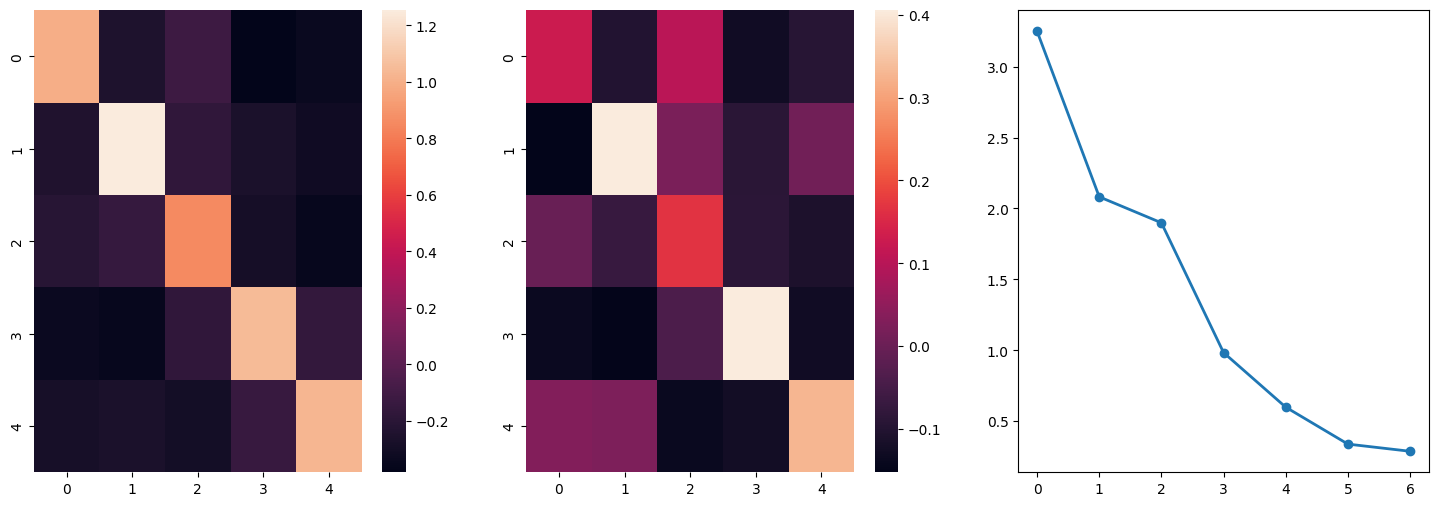

In [30]:
rank_select = 7

U_qk, s_qk, Vt_qk = np.linalg.svd(W_qk)
U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov)
W_qk_denoise = U_qk[:,:rank_select] @ np.diag(s_qk[:rank_select]) @ Vt_qk[:rank_select,:]
W_ov_denoise = U_ov[:,:rank_select] @ np.diag(s_ov[:rank_select]) @ Vt_ov[:rank_select,:]
W_qkov_denoise = W_qk_denoise @ W_ov_denoise

_, s_match_denoise, _ = np.linalg.svd(W_qkov_denoise)
s_match_denoise = s_match_denoise[:rank_select]

fig, axs = plt.subplots(1, 3, figsize=(6*3, 6*1))
sns.heatmap(W_qkov[:vocab_size, :vocab_size], ax=axs[0])
sns.heatmap(W_qkov_denoise[:vocab_size, :vocab_size], ax=axs[1])
axs[2].plot(s_match_denoise, '-o', label='qkov', linewidth=2)
plt.show()